In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support
)

from scipy.stats import randint

In [ ]:
#Rutas de los embeddings
TRAIN_EMB_PATH = "/content/drive/MyDrive/tesis/embeddings_3dino_TRAIN_aug10k_seed42_finn.npz"
TEST_EMB_PATH  = "/content/drive/MyDrive/tesis/embeddings_3dino_TEST_seed42_fin.npz"

VAL_SIZE = 0.10   # 90/10
RANDOM_STATE = 42

In [ ]:
# Carga de embeddings guardados en .npz
def load_npz_embeddings(path):
    data = np.load(path, allow_pickle=True)
    print(f"\nArchivo: {path}")
    print("Keys encontradas:", list(data.keys()))


    if "X" in data and "y" in data:
        X, y = data["X"], data["y"]
    elif "embeddings" in data and "labels" in data:
        X, y = data["embeddings"], data["labels"]
    else:
        raise ValueError("No encuentro las llaves X/y o embeddings/labels.")

    X = np.asarray(X)
    y = np.asarray(y).reshape(-1).astype(int)
    return X, y

# Carga embeddings y etiquetas del conjunto de entrenamiento
X_train_full, y_train_full = load_npz_embeddings(TRAIN_EMB_PATH)
# Carga embeddings y etiquetas del conjunto de prueba
X_test, y_test = load_npz_embeddings(TEST_EMB_PATH)

print("\nResumen:")
print("Train:", X_train_full.shape, np.unique(y_train_full, return_counts=True))
print("Test :", X_test.shape, np.unique(y_test, return_counts=True))


Archivo: /content/drive/MyDrive/tesis/embeddings_3dino_TRAIN_aug10k_seed42_finn.npz
Keys encontradas: ['embeddings', 'labels', 'paths']

Archivo: /content/drive/MyDrive/tesis/embeddings_3dino_TEST_seed42_fin.npz
Keys encontradas: ['embeddings', 'labels', 'paths']

Resumen:
Train: (35000, 1024) (array([1, 2, 3, 4, 5]), array([7000, 7000, 7000, 7000, 7000]))
Test : (2542, 1024) (array([1, 2, 3, 4, 5]), array([1148,  204,  128,  945,  117]))


In [ ]:
# Divide el conjunto de entrenamiento en Train y Validation
# - test_size define el porcentaje que se reserva para validación
# - stratify mantiene la misma proporción de clases en ambos conjuntos
# - random_state fija la aleatoriedad para que el split sea reproducible
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=RANDOM_STATE,
    stratify=y_train_full
)

print("Train:", X_train.shape)
print("Val  :", X_val.shape)


Train: (31500, 1024)
Val  : (3500, 1024)


In [ ]:
# Evalúa un modelo de clasificación y muestra métricas + reportes + matrices de confusión
def evaluate_model(model, X, y, title=""):
    y_pred = model.predict(X)

    acc = accuracy_score(y, y_pred)
    pr_m, rc_m, f1_m, _ = precision_recall_fscore_support(
        y, y_pred, average="macro", zero_division=0
    )
    pr_w, rc_w, f1_w, _ = precision_recall_fscore_support(
        y, y_pred, average="weighted", zero_division=0
    )

    print(f"\n===== {title} =====")
    print(f"Accuracy: {acc:.6f}")
    print(f"Macro    -> Precision: {pr_m:.6f} | Recall: {rc_m:.6f} | F1: {f1_m:.6f}")
    print(f"Weighted -> Precision: {pr_w:.6f} | Recall: {rc_w:.6f} | F1: {f1_w:.6f}")
    print("\nClassification report:")
    print(classification_report(y, y_pred, digits=6, zero_division=0))

    # Matriz de confusión (conteos)
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(values_format="d")
    plt.title(f"Confusion Matrix – {title}")
    plt.show()

    # Matriz de confusión normalizada
    cmn = confusion_matrix(y, y_pred, normalize="true")
    disp2 = ConfusionMatrixDisplay(confusion_matrix=cmn)
    disp2.plot(values_format=".2f")
    plt.title(f"Confusion Matrix Normalizada – {title}")
    plt.show()

    return y_pred


===== VALIDACIÓN (RF base) =====
Accuracy: 0.669429
Macro    -> Precision: 0.667252 | Recall: 0.669429 | F1: 0.666579
Weighted -> Precision: 0.667252 | Recall: 0.669429 | F1: 0.666579

Classification report:
              precision    recall  f1-score   support

           1   0.973239  0.987143  0.980142       700
           2   0.546229  0.641429  0.590013       700
           3   0.661912  0.662857  0.662384       700
           4   0.519298  0.422857  0.466142       700
           5   0.635581  0.632857  0.634216       700

    accuracy                       0.669429      3500
   macro avg   0.667252  0.669429  0.666579      3500
weighted avg   0.667252  0.669429  0.666579      3500



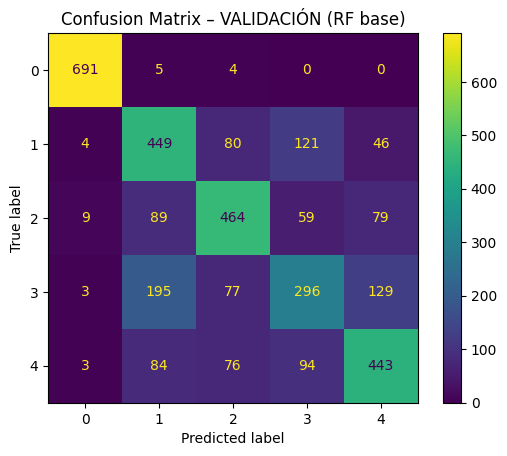

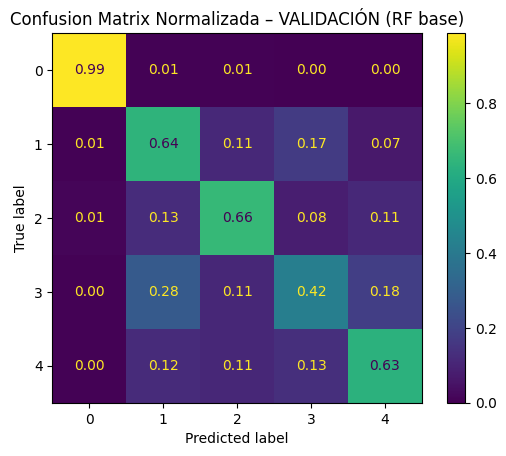


===== TEST (RF base) =====
Accuracy: 0.675452
Macro    -> Precision: 0.514112 | Recall: 0.607658 | F1: 0.503944
Weighted -> Precision: 0.797018 | Recall: 0.675452 | F1: 0.687548

Classification report:
              precision    recall  f1-score   support

           1   0.987900  0.995645  0.991757      1148
           2   0.281395  0.593137  0.381703       204
           3   0.241270  0.593750  0.343115       128
           4   0.820779  0.334392  0.475188       945
           5   0.239216  0.521368  0.327957       117

    accuracy                       0.675452      2542
   macro avg   0.514112  0.607658  0.503944      2542
weighted avg   0.797018  0.675452  0.687548      2542



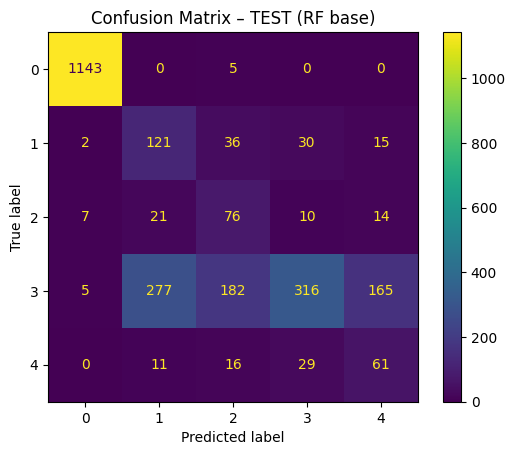

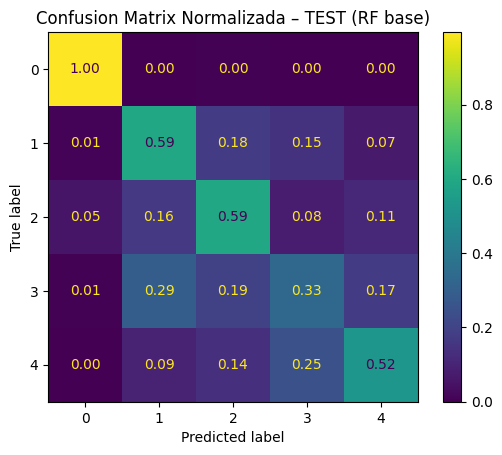

In [ ]:
# Modelo baseline: Random Forest
rf_base = RandomForestClassifier(
    n_estimators=800,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

# Entrena el modelo con el conjunto de entrenamiento
rf_base.fit(X_train, y_train)

_ = evaluate_model(rf_base, X_val, y_val, "VALIDACIÓN (RF base)")
_ = evaluate_model(rf_base, X_test, y_test, "TEST (RF base)")

In [ ]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Espacio de búsqueda de hiperparámetros para Random Forest
param_dist_ultra = {
    "n_estimators": [150, 250, 350, 450],
    "max_depth": [20, 30, 40, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
    "bootstrap": [True],
    "class_weight": ["balanced_subsample"]
}

# Validación cruzada estratificada:
# Mantiene proporciones de clases en cada fold y mezcla el orden para mayor robustez
cv_ultra = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# Búsqueda aleatoria de hiperparámetros:
# Prueba n_iter combinaciones aleatorias dentro del espacio definido y elige la mejor según f1_macro
search = RandomizedSearchCV(
search = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        max_samples=0.7
    ),
    param_distributions=param_dist_ultra,
    n_iter=10,            # 10 candidatos -> 10*3 = 30 fits
    scoring="f1_macro",
    cv=cv_ultra,
    random_state=RANDOM_STATE,
    n_jobs=1,
    verbose=2
)

search.fit(X_train_full, y_train_full)

print("\nBest params:", search.best_params_)
print("Best CV f1_macro:", search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=250; total time= 1.5min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 4.7min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=250; total time= 4.8min
[CV] END bootstrap=True, class_weight=balanced_subsample, max_depth=40, max_features=sqrt, 


===== VALIDACIÓN (RF optimizado) =====
Accuracy: 0.664000
Macro    -> Precision: 0.661509 | Recall: 0.664000 | F1: 0.661422
Weighted -> Precision: 0.661509 | Recall: 0.664000 | F1: 0.661422

Classification report:
              precision    recall  f1-score   support

           1   0.974576  0.985714  0.980114       700
           2   0.551425  0.635714  0.590577       700
           3   0.656160  0.654286  0.655222       700
           4   0.503413  0.421429  0.458787       700
           5   0.621969  0.622857  0.622413       700

    accuracy                       0.664000      3500
   macro avg   0.661509  0.664000  0.661422      3500
weighted avg   0.661509  0.664000  0.661422      3500



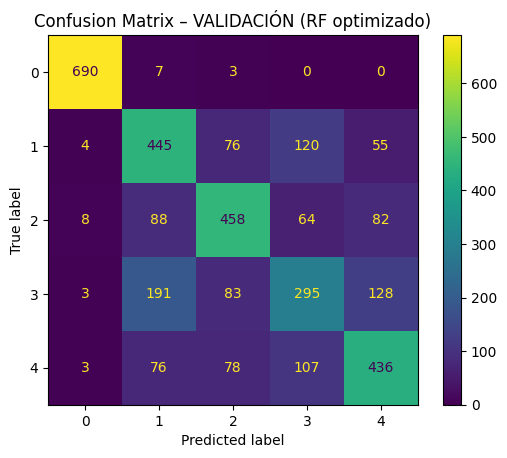

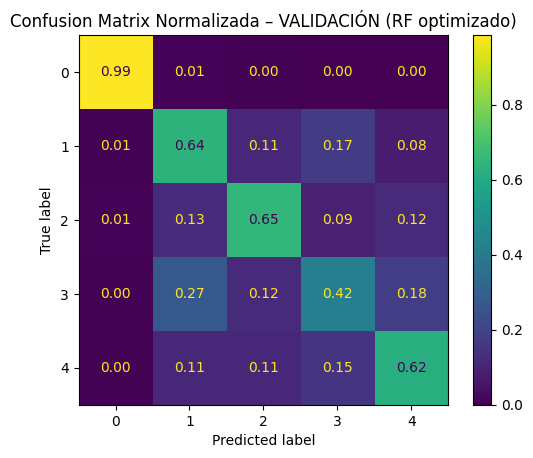


===== TEST (RF optimizado, entrenado con todo TRAIN) =====
Accuracy: 0.673879
Macro    -> Precision: 0.510866 | Recall: 0.599726 | F1: 0.500128
Weighted -> Precision: 0.794282 | Recall: 0.673879 | F1: 0.685945

Classification report:
              precision    recall  f1-score   support

           1   0.985357  0.996516  0.990905      1148
           2   0.272523  0.593137  0.373457       204
           3   0.250000  0.570312  0.347619       128
           4   0.818653  0.334392  0.474831       945
           5   0.227799  0.504274  0.313830       117

    accuracy                       0.673879      2542
   macro avg   0.510866  0.599726  0.500128      2542
weighted avg   0.794282  0.673879  0.685945      2542



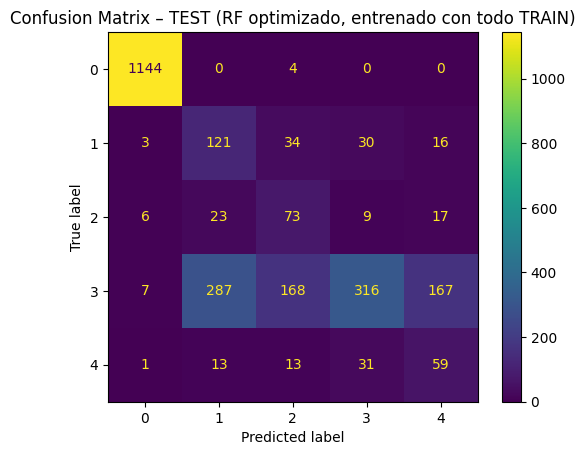

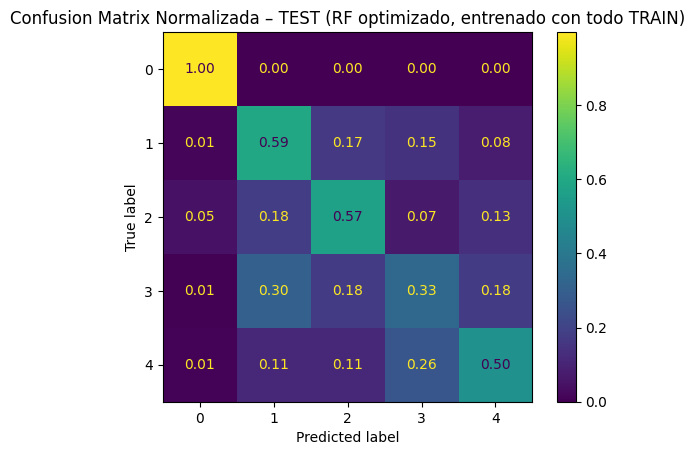

In [ ]:
# Obtiene el mejor modelo encontrado por RandomizedSearchCV
best_rf = search.best_estimator_

# Entrena el modelo optimizado solo con X_train para comparar de forma justa contra el baseline
best_rf.fit(X_train, y_train)
# Evalúa en el conjunto de validación (sirve para comparar configuraciones sin tocar el test)
_ = evaluate_model(best_rf, X_val, y_val, "VALIDACIÓN (RF optimizado)")

# Entrenamiento final para reporte
best_rf.fit(X_train_full, y_train_full)
_ = evaluate_model(best_rf, X_test, y_test, "TEST (RF optimizado, entrenado con todo TRAIN)")
